## Subtyping Mitotic Figures (MF) and Mitotic-Like Figures (MLFs) 

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
import numpy as np
from numpy.core.multiarray import packbits
import pandas as pd
import os
from os import listdir
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [25]:
#This cell is only relevant if using Google Colab and Google Drive.  It should not be run unless running this Jupyter Notebook in Google Colab.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [29]:
#This cell is only relevant if using Google Colab and Google Drive.  It should not be run unless running this Jupyter Notebook in Google Colab.
%cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/My Drive/MITOS_WSI_CMC


Data Upload and Data Cleaning

In [33]:
#Here, we read in FSL annotations and concatenate them into a single Pandas dataframe.
data1 = pd.read_csv('fsl_subclassing/slide_2_updated/20221116-115200_ann_df_re-subcl_slide_no_2_all_64_MFs.csv')
data2 = pd.read_csv('fsl_subclassing/slide_2/20221030-011825_annot_df_sorted_subclassed_MLFs_32_slide_no_2.csv')
data3 =  pd.read_csv('fsl_subclassing/slide_3/20221112-015900_annot_df_sorted_subclassed_MLFs_72_slide_no_3.csv')
data4 =  pd.read_csv('fsl_subclassing/slide_3/20221112-003547_annot_df_sorted_subclassed_slide_no_3_all_MFs.csv')
data5 = pd.read_csv('fsl_subclassing/slide_5/20221112-230321_annot_df_sorted_subclassed_MLFs_100_slide_no_5.csv')
data6 = pd.read_csv('fsl_subclassing/slide_5/221211-35722_ann_df_subcl_CORRECTED_sl_5_all_130_MFs.csv')
data7 = pd.read_csv('fsl_subclassing/slide_7/20221115-150013_annot_df_sorted_subclassed_MLFs_160_slide_no_7.csv')
data8 = pd.read_csv('fsl_subclassing/slide_7/20221115-150013_ann_df_subcl_slide_no_7_all_157_MFs.csv')
data9 = pd.read_csv('fsl_subclassing/slide_8/20221116-092800_ann_df_subcl_slide_no_8_all_187_MFs.csv')
data10 = pd.read_csv('fsl_subclassing/slide_8/20221116-092800_annot_df_sorted_subclassed_MLFs_100_slide_no_8.csv')
data = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9,data10])


In [5]:
#This cell is only relevant if using Google Colab and Google Drive.  It should not be run unless running this Jupyter Notebook in Google Colab.
%cd MITOS_WSI_CMC/databases

/content/drive/MyDrive/MITOS_WSI_CMC/databases


In [35]:
#The FSL annotations have labels 9 and 42, which are equivalent, and 0, none of which should be used for training.  We drop these.
data.head()
data['subcl'] = data['subcl'].replace(42,9)
data_filtered = data[data['subcl'] != 9]
data = data_filtered.copy()
data = data[data['subcl'] != 0]

In [37]:
#The FSL subclass annotations extracted from the dataframe to train on.
subclass_annotations = data.drop(['ctr', 'coord', 'guid'], axis = 1)
subclass_annotations.head()
len(subclass_annotations)

984

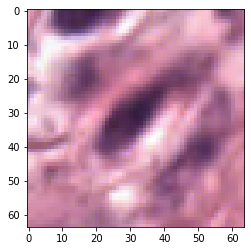

In [43]:
#Here, we load the images from the files we wrote during the patch extraction step.

labels = subclass_annotations['subcl']
imagelist = []

# get the path/directory
folder_dir = "databases"
i = 0
while (i<93):
        temp = mpimg.imread('/content/drive/MyDrive/MITOS_WSI_CMC/databases/patchExtraction_final/' + str(2) + str(i) + str('.png'))
        plt.imshow(temp)
        #temp = cv2.copyMakeBorder(temp, 87, 87, 87, 87, cv2.BORDER_CONSTANT)
        plt.imshow(temp)
        imagelist.append(temp)
        i = i + 1
i = 0
while (i<155):
        temp = mpimg.imread('/content/drive/MyDrive/MITOS_WSI_CMC/databases/patchExtraction_final/' + str(3) + str(i) + str('.png'))
        plt.imshow(temp)
        #temp = cv2.copyMakeBorder(temp, 87, 87, 87, 87, cv2.BORDER_CONSTANT)
        plt.imshow(temp)
        imagelist.append(temp)
        i = i + 1
i = 0
while (i<203):
        temp = mpimg.imread('/content/drive/MyDrive/MITOS_WSI_CMC/databases/patchExtraction_final/' + str(5) + str(i) + str('.png'))
        plt.imshow(temp)
        #temp = cv2.copyMakeBorder(temp, 87, 87, 87, 87, cv2.BORDER_CONSTANT)
        plt.imshow(temp)
        imagelist.append(temp)
        i = i + 1
i = 0
while (i<303):
        temp = mpimg.imread('/content/drive/MyDrive/MITOS_WSI_CMC/databases/patchExtraction_final/' + str(7) + str(i) + str('.png'))
        plt.imshow(temp)
        #temp = cv2.copyMakeBorder(temp, 87, 87, 87, 87, cv2.BORDER_CONSTANT)
        plt.imshow(temp)
        imagelist.append(temp)
        i = i + 1
i = 0
while (i<230):
        temp = mpimg.imread('/content/drive/MyDrive/MITOS_WSI_CMC/databases/patchExtraction_final/' + str(8) + str(i) + str('.png'))
        plt.imshow(temp)
        #temp = cv2.copyMakeBorder(temp, 87, 87, 87, 87, cv2.BORDER_CONSTANT)
        plt.imshow(temp)
        imagelist.append(temp)
        i = i + 1


In [45]:
#Here, we collapse labels 3,4, and 5 into just label 5.  
labels = np.asarray(labels)
i = 0
while i<len(labels):
    if (np.equal(int(labels[i]),3)):
       labels[i] = 5
    elif (np.equal(int(labels[i]),4)):
       labels[i] = 5
    i = i + 1


In [46]:
#Labels are manually one-hot encoded.
i = 0
ohe_labels = [0] * len(labels)
while (i<len(labels)):
      if (labels[i] == 5):
         ohe_labels[i] = [0, 0, 0, 1]
      elif (labels[i] == 6):
         ohe_labels[i] = [0, 0, 1, 0]
      elif (labels[i] == 7):
         ohe_labels[i] = [0, 1, 0, 0]
      elif (labels[i] == 8):
         ohe_labels[i] = [1, 0, 0, 0]
      i = i + 1

In [47]:
#Labels and images are put into "X" and "y" for the train-test split step.
X = imagelist.copy()
X = np.asarray(X)
y = np.asarray(ohe_labels)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

III. VGG16 for Classification

In [66]:
#VGG16 is initialized.

vgg_model = tf.keras.applications.VGG16(include_top=False,weights="imagenet",input_shape=(64,64,3),classifier_activation="relu")




In [67]:
#The sizes of the dense layers were chosen as multiples of the number of classes.
model = models.Sequential()
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='softmax'))


In [68]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.0001,momentum=0.0,nesterov=False,name='SGD'), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_test , y_test))

Epoch 1/50
22/22 [==============================] - 150s 7s/step - loss: 1.3907 - accuracy: 0.2936 - val_loss: 1.3069 - val_accuracy: 0.4088
Epoch 2/50
22/22 [==============================] - 150s 7s/step - loss: 1.2861 - accuracy: 0.4201 - val_loss: 1.2681 - val_accuracy: 0.4189
Epoch 3/50
22/22 [==============================] - 145s 7s/step - loss: 1.2575 - accuracy: 0.4520 - val_loss: 1.2522 - val_accuracy: 0.4358
Epoch 4/50
22/22 [==============================] - 155s 7s/step - loss: 1.2390 - accuracy: 0.4578 - val_loss: 1.2424 - val_accuracy: 0.4324
Epoch 5/50
22/22 [==============================] - 149s 7s/step - loss: 1.2233 - accuracy: 0.4637 - val_loss: 1.2323 - val_accuracy: 0.4459
Epoch 6/50
22/22 [==============================] - 148s 7s/step - loss: 1.2089 - accuracy: 0.4695 - val_loss: 1.2264 - val_accuracy: 0.4561
Epoch 7/50
22/22 [==============================] - 153s 7s/step - loss: 1.1956 - accuracy: 0.4709 - val_loss: 1.2198 - val_accuracy: 0.4561
Epoch 8/50
22

KeyboardInterrupt: ignored

In [69]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1) + 5

10/10 [==============================] - 25s 3s/step


In [70]:
print(y_pred)

[6 6 5 6 6 5 8 5 5 5 5 5 5 6 6 5 5 5 5 5 8 8 8 5 8 5 6 5 6 5 6 8 5 5 8 8 5
 5 5 5 5 6 8 5 8 6 5 5 8 5 6 5 5 6 5 5 5 6 6 8 5 8 6 5 5 5 8 5 5 5 5 6 6 5
 5 5 8 6 5 8 8 5 6 5 6 5 5 5 8 8 8 5 8 5 5 6 5 6 5 5 5 5 5 5 5 5 8 8 5 5 5
 8 5 8 8 5 5 6 5 6 6 5 5 8 8 8 6 8 5 6 5 8 5 5 8 5 5 5 5 6 6 5 5 5 5 6 5 5
 5 5 5 5 8 5 6 5 5 5 5 5 5 5 5 6 8 5 8 8 5 5 5 6 5 5 5 8 7 6 8 5 5 6 6 6 5
 6 6 5 5 5 6 5 6 6 5 6 5 5 5 5 5 5 5 5 5 5 6 8 5 6 6 6 5 5 5 5 5 6 6 6 6 6
 5 5 5 5 5 5 5 5 5 5 5 5 7 5 8 5 5 6 6 5 8 5 8 5 6 5 6 6 5 5 5 8 8 5 6 6 8
 6 8 5 5 6 5 5 5 5 8 5 5 8 8 5 5 6 5 6 8 5 8 8 6 8 5 6 5 5 5 8 5 5 8 6 5 6]
